# Forecast
***

**Author**: Chus Casado<br>
**Date**: 19-01-2023<br>

**Introduction**:<br>


**Questions**:<br>
* The ECMWF ensemble forecast hast only 15 timesteps (aprox. 5 days), instead of 10 days.
* The forecasts from DWD and EUD the 2018-06-20 12:00:00 is missing.
* How to remove temporal autocorrelation?
* See if floods were ever notified?

**Tasks to do**:<br>

- [ ] Find how many formal notifications would have been sent.

**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

# 1 Data

In [2]:
catchment = 'Ebro'

# shapefile with rivers
rivers = gpd.read_file(f'../data/GIS/A3RIOS_{catchment}.shp')

### 1.1 Stations 

In [3]:
# load selected points
stations = pd.read_csv(f'results/{catchment}/points_selected.csv', index_col='station_id')
print('no. stations:\t{0}'.format(stations.shape[0]))

no. stations:	50


### 1.2 Discharge forecast

#### List available data

In [5]:
models = ['COS', 'DWD', 'EUD', 'EUE']

In [6]:
# list files
fore_files = {model: [] for model in models}
for year in [2020, 2021, 2022]:
    for month in range(1, 13):    
        # list files
        for model in models:
            fore_files[model] += glob.glob(f'{path_forecast}{model}/{year}/{month:02d}/*.nc')

# count files and check if all are avaible
n_files = pd.Series(data=[len(fore_files[model]) for model in models], index=models)

# list of forecast from the beginning to the end of the data
start, end = datetime(1900, 1, 1), datetime(2100, 1, 1)
for model in models:
    st, en = [datetime.strptime(fore_files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = max(st, start)
    end = min(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in fore_files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print('mising files:', missing)

# trim files to the period where all models are available
for model in models:
    fore_files[model] = [file for file in fore_files[model] if start <= datetime.strptime(file[-13:-3], '%Y%m%d%H') <= end]
    print('{0}:\t{1} files'.format(model, len(fore_files[model])))

mising files: {'COS': [], 'DWD': [], 'EUD': [], 'EUE': []}
COS:	730 files
DWD:	730 files
EUD:	730 files
EUE:	730 files


### 1.3 Discharge reanalysis

In [7]:
# load discharge reanalysis data
rean_files = glob.glob(f'../data/CDS/reanalysis/*202*.csv')
if 'reanalysis' in locals():
    del reanalysis
for file in rean_files:
    temp = pd.read_csv(file, parse_dates=True, index_col=0)
    if 'reanalysis' in locals():
        reanalysis = pd.concat((reanalysis, temp), axis=0)
    else:
        reanalysis = temp.copy()
    del temp

# cut the timeseries from 14-10-2020 12 pm and the selected reporting points
reanalysis.columns = reanalysis.columns.astype(int)
reanalysis = reanalysis.loc[start:end, stations.index]

print('Reanalysis timeseries:\n{0}\ttimesteps\n{1}\tstations'.format(*reanalysis.shape))

Reanalysis timeseries:
1459	timesteps
50	stations


## 2 Analysis

### 2.1 Flood events in the reanalysis data

no. stations with events:	15
total no. events:		20


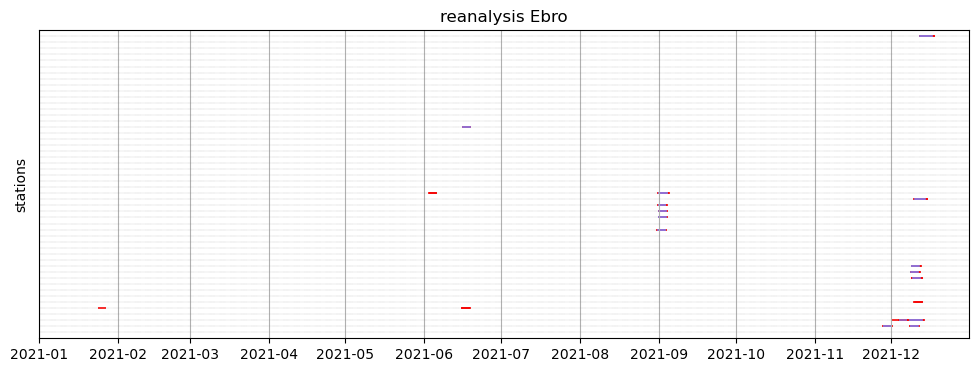

In [9]:
# compute exceedances of the discharge threshold
rean_exc = (reanalysis > stations.rl5).astype(int)
rean_events = rean_exc.diff() == 1
# compute number of events in each station
stations['n_events_5'] = rean_events.sum(axis=0)

print('no. stations with events:\t{0}'.format(stations.loc[stations.n_events_5 > 0, :].shape[0]))
print('total no. events:\t\t{0}'.format(stations.n_events_5.sum()))

thrs = ['rl5', 'rl20']
figsize = (12, 4)
exceedances_timeline(reanalysis, stations, thresholds=thrs, figsize=figsize, grid=True, title=f'reanalysis {catchment}')

Station 4627 - 3 events: [Timestamp('2021-12-03 00:00:00'), Timestamp('2021-12-05 06:00:00'), Timestamp('2021-12-09 12:00:00')]


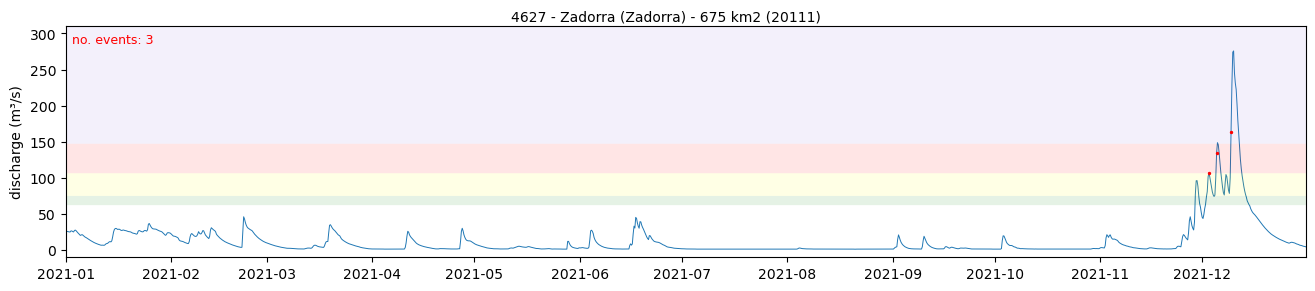

In [12]:
# list of stations with events
stns = rean_events.loc[rean_events.any(axis=1), rean_events.any(axis=0)].columns.tolist()
# station with more events
stn = rean_events[stns].sum().idxmax()

# list of the onset of events in that station
mask = (rean_events[stn].astype(int).diff() == 1)
events = rean_events.index[mask].tolist()

print('Station {0} - {1} events: {2}'.format(stn, len(events), events))

title = '{0} - {1} ({2}) - {3:.0f} km2 ({4:.0f})'.format(stn, *stations.loc[stn, ['river', 'subcatchment', 'area', 'pfafstetter']])
plot_events_timeseries(reanalysis[stn], rean_events[stn], thresholds=stations.loc[stn, ['rl1.5', 'rl2', 'rl5', 'rl20']],
                       title=title)

### 2.2 Flood events in the reforecast data

In [13]:
n_stations = stations.shape[0]
path = f'../data/exceedance/forecast/'

for i, stn in enumerate(stations.index):    
    
    file = f'{stn:04d}.nc'
    if file in os.listdir(path):
        print(f'File {file} already exists')
        continue
            
    dct = {}
    for model in models:
        
        print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d}) - {model}', end='\r')
        
        # compute exceedance of discharge threshold
        exceedance = compute_exceedance(fore_files[model], str(stn), stations.loc[stn, 'rl5'])
        # limit to 10 days leadtime
        if len(exceedance.leadtime) > 41:
            exceedance = exceedance.isel(leadtime=slice(0, 41))
        # if probabilistic, compute probability of exceedance
        if 'member' in exceedance.dims:
            dct[model] = exceedance.mean('member')
        else:
            dct[model] = exceedance
    
    # convert exceedance data into a Dataset
    ds = xr.Dataset(dct, coords={'forecast': dct['EUE'].forecast, 'leadtime': dct['EUE'].leadtime})

    # convert the dataset into a DataArray in which models is a dimension instead of different variables
    da_list = [ds[model].expand_dims('model', axis=0).assign_coords(model=[model]).rename('exceedance') for model in models]
    da = xr.merge(da_list)['exceedance']
    
    # export as NetCDF
    da.to_netcdf(f'{path}{file}')

In [ ]:
stn = stns[0]

fore_exc = {}
members = []
leadtimes = []
for model in models:
    # compute exceedance of discharge threshold
    exceedance = compute_exceedance(fore_files[model], str(stn), stations.loc[stn, 'rl5'])
    # limit to 10 days leadtime
    if len(exceedance.leadtime) > 41:
        exceedance = exceedance.isel(leadtime=slice(0, 41))
    # if probabilistic, compute probability of exceedance
    if 'member' in exceedance.dims:
        fore_exc[model] = exceedance.mean('member')
        members.append(len(exceedance.member))
    else:
        fore_exc[model] = exceedance
        members.append(1)
    leadtimes.append(len(exceedance.leadtime))

In [ ]:
# convert exceedance data into a Dataset
fore_exc_ds = xr.Dataset(fore_exc, coords={'forecast': fore_exc['EUE'].forecast, 'leadtime': fore_exc['EUE'].leadtime})

# convert the dataset into a DataArray in which models is a dimension instead of different variables
da_list = [fore_exc_ds[model].expand_dims('model', axis=0).assign_coords(model=[model]).rename('exceedance') for model in models]
fore_exc_da = xr.merge(da_list)['exceedance']

In [ ]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(models), max(leadtimes)))
for i, (model, member, leadtime) in enumerate(zip(models, members, leadtimes)):
    weights[i,:leadtime] = member
weights = xr.DataArray(weights, coords={'model': models, 'leadtime': fore_exc_da.leadtime})

In [ ]:
# setup the plot
nrows = len(models) + 2
fig, axes = plt.subplots(nrows=nrows, figsize=(16, 4 * nrows), sharey=True, sharex=True)

# each NWP model
for ax, model in zip(axes, fore_exc_da.model.data):
    heatmap_forecast(fore_exc_da.sel(model=model), events=events, title=model, label='exceedance probability (-)', ax=ax)
    
# mean across equally-weighted models
model_mean = fore_exc_da.mean('model')
heatmap_forecast(model_mean, events=events, title='model mean', label='exceedance probability (-)', ax=axes[-2])

# weighted-mean across models
weighted_mean = fore_exc_da.weighted(weights).mean('model')
heatmap_forecast(weighted_mean, events=events, title='weighted mean', label='exceedance probability (-)', ax=axes[-1])

### 2.3 Prediction skill

In [ ]:
# probability threshold
p_thr = .3

In [ ]:
# dataset where all criteria will ve saved
criteria = xr.Dataset(coords={'forecast': fore_exc_da.forecast, 'leadtime': fore_exc_da.leadtime})

# find where the deterministic criteria was fulfilled
criteria['deterministic'] = fore_exc_da.sel(model=['DWD', 'EUD']).sum('model')
# find where the probabilistic criteria was fulfilled
criteria['probabilistic'] = ((fore_exc_da.sel(model='COS') > p_thr).astype(int) + (fore_exc_da.sel(model='EUE') > p_thr).astype(int))
# find where both the deterministic and the probabilistic criteria was fulfilled
criteria['current'] = ((criteria['deterministic'] >= 1) & (criteria['probabilistic'] >= 1))#.astype(int)
# find where the model mean exceeds the probability threshold
criteria['model_mean'] = (model_mean > p_thr)#.astype(int)
# find where the grand ensemble exceeds the probability threshold
criteria['grand_ensemble'] = (weighted_mean > p_thr)#.astype(int)

# plot
for variable, da in criteria.data_vars.items():
    if variable in ['deterministic', 'probabilistic']:
        label, vmax = 'no. models (-)', 2
    else:
        label, vmax = None, 1
    heatmap_forecast(da, events, vmin=0, vmax=vmax, title=variable, label=label)

In [ ]:
# create DataArray of the occurrence of events
events_da = dataarray_events(events, fore_exc_da.forecast, fore_exc_da.leadtime)

fig, ax = plt.subplots(figsize=(16, 4))
# heatmap_forecast(criteria['current'], events, vmax=1, title='notifications according to weighted mean', ax=ax)
heatmap_forecast(events_da, cmap='Reds', vmax=2, alpha=.1, cbar=False, ax=ax);

In [ ]:
notification = xr.Dataset(coords=criteria.coords)
for variable in ['current', 'model_mean', 'grand_ensemble']:
    
    da = criteria[variable]
    
    # find first leadtime that exceeds the threshold for each event
    steps = da.astype(int).diff('leadtime') == 1
    step1 = da.isel(leadtime=0)
    # steps.loc[step1] = False
    notification[variable] = xr.concat((step1, steps), 'leadtime')

# plot
for variable, da in notification.data_vars.items():
    heatmap_forecast(da, events, vmin=0, vmax=1, title=variable, label='notification')

In [ ]:
compute_performance(notification, events_da)

**Daily resample**

In [ ]:
resample_dict = {'leadtime': 'd'}
events_daily = events_da.resample(resample_dict).any()
notification_d = xr.Dataset({variable: da.resample(resample_dict).any() for variable, da in notification.data_vars.items()})
notification_d = xr.Dataset(notification_d)

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_d.data_vars.items()):
    heatmap_forecast(da, events, leadtime_grid=1, title=variable, ax=ax)
    #heatmap_forecast(events_daily, vmax=2, cmap='Reds', alpha=.1, leadtime_grid=1, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_d, events_daily)

**Rolling sum**

In [ ]:
w = 5
rolling_dict = {'leadtime': w}
mp = int(w / 2) + 1
notification_r = xr.Dataset({var: da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0 for var, da in notification.data_vars.items()})
events_r = events_da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_r.data_vars.items()):
    heatmap_forecast(da, events=None, vmax=2, title=variable, ax=ax)
    heatmap_forecast(events_da, vmax=2, cmap='Reds', alpha=.5, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_r, events_da)

In [ ]:
compute_performance(notification_r, events_r)

In [ ]:
events_da.sum('leadtime')

In [ ]:
ev = events_da.isel(forecast=i)

In [ ]:
da = notification['model_mean']
da.sum('leadtime')

In [ ]:
i = 47

In [ ]:
y_true = events_da.isel(forecast=i).data.astype(float)

y_pred1 = da.isel(forecast=i).data.astype(float)
cm1 = confusion_matrix(y_true, y_pred1)

In [ ]:
y_pred0 = da.isel(forecast=i).shift(leadtime=1).data.astype(float)
y_pred0[0] = 0
cm0 = confusion_matrix(y_true, y_pred0)

In [ ]:
y_pred2 = da.isel(forecast=i).shift(leadtime=-1).data.astype(float)
y_pred2[-1] = 0
cm2 = confusion_matrix(y_true, y_pred2)

In [ ]:
np.max(cm0, cm1, cm2)

In [ ]:
# tmp = xr.DataArray([[0, 0, 1], [0, 1, 0], [1, 0, 0]], coords={'x': [1, 2, 3], 'y': [1, 2, 3]})
# tmp

# tmp.diff('y', label='upper')

# tmp.diff('y', label='lower')

## Compute formal notifications

* One probabilistic forecast (_EUE_ or _COSMO_) exceeds Q5:
    * With a probability of exceedance $\geq 30 \%$
    * In 3 consecutive forecasts
* One deterministic forecasts (_EUD_ or _DWD_) exceeds Q5
* Catchment area $\geq 2000 km^2$
* Lead time $\geq 48 h$

In [ ]:
stations_sel[['f1', 'recall', 'precision']] = np.nan
for i, (stn, Q5) in enumerate(zip(stations_sel.index, stations_sel.Q5)):

    ### REFORECAST

    # compute exceedance of Q5
    fore_exc = {model: compute_exceedance(files[model], stn, Q5) for model in models}
    # compute formal notifications
    notifications = compute_notifications(fore_exc, leadtime=4, probability=.3, persistence=3)

    ### REANALYSIS

    # Compute exceedance
    rea_exc = (reanalysis[stn] >= Q5).astype(int)

    # check if there was an event in each of the forecast windows
    events = []
    for forecast in notifications.forecast.values:
        start = forecast
        end = start + np.timedelta64(10, 'D')
        events.append(rea_exc[start:end].any())
    events = xr.DataArray(events, dims='forecast', coords={'forecast': notifications.forecast})

    # SKILL
    stations_sel.loc[stn, 'f1'] = f1_score(events, notifications)
    stations_sel.loc[stn, 'recall'] = recall_score(events, notifications)
    stations_sel.loc[stn, 'precision'] = precision_score(events, notifications)
    
    print('station {0:<3} of {1:<3} | {2:>4}:\t{3:.3f}'.format(i + 1, stations_sel.shape[0], stn, stations_sel.loc[stn, 'f1']))

In [ ]:
stations_sel[['f1', 'recall', 'precision']].describe()

In [ ]:
im = plt.scatter(stations_sel.LisfloodX, stations_sel.LisfloodY, s=stations_sel['DrainingArea.km2.LDD'] / 1000,
                 c=stations_sel.recall, cmap='virireanalysis', vmin=0, vmax=1)
plt.colorbar(im);

In [ ]:
stations_sel.loc[stations_sel.f1 == 0]

In [ ]:
stations_sel.to_csv(f'../data/stations_{catchment}.csv', float_format='%.3f')

For each station:
1. Identify flood events.
2